BERT BASED FAKE NEWS DETECTION

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import os

# dataset path
dataset_path = '/content/drive/MyDrive/fake-news-detection/Dataset/'

# Load the TSV files
train_df = pd.read_csv(os.path.join(dataset_path, 'multimodal_train.tsv'), sep='\t')
validate_df = pd.read_csv(os.path.join(dataset_path, 'multimodal_validate.tsv'), sep='\t')
test_df = pd.read_csv(os.path.join(dataset_path, 'multimodal_test_public.tsv'), sep='\t')

print("Training set shape:", train_df.shape)
print("\nValidation set shape:", validate_df.shape)
print("\nTest set shape:", test_df.shape)

Training set shape: (564000, 16)

Validation set shape: (59342, 16)

Test set shape: (59319, 16)


In [29]:
train_df.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


In [30]:
columns=["clean_title","6_way_label"]
df_train=train_df[columns]
df_test=test_df[columns]
df_validate=validate_df[columns]


In [31]:
df_train.isna().sum()

,0
clean_title,0
6_way_label,0


In [32]:
df_validate.isna().sum()

,0
clean_title,0
6_way_label,0


In [33]:
df_test.isna().sum()

,0
clean_title,0
6_way_label,0


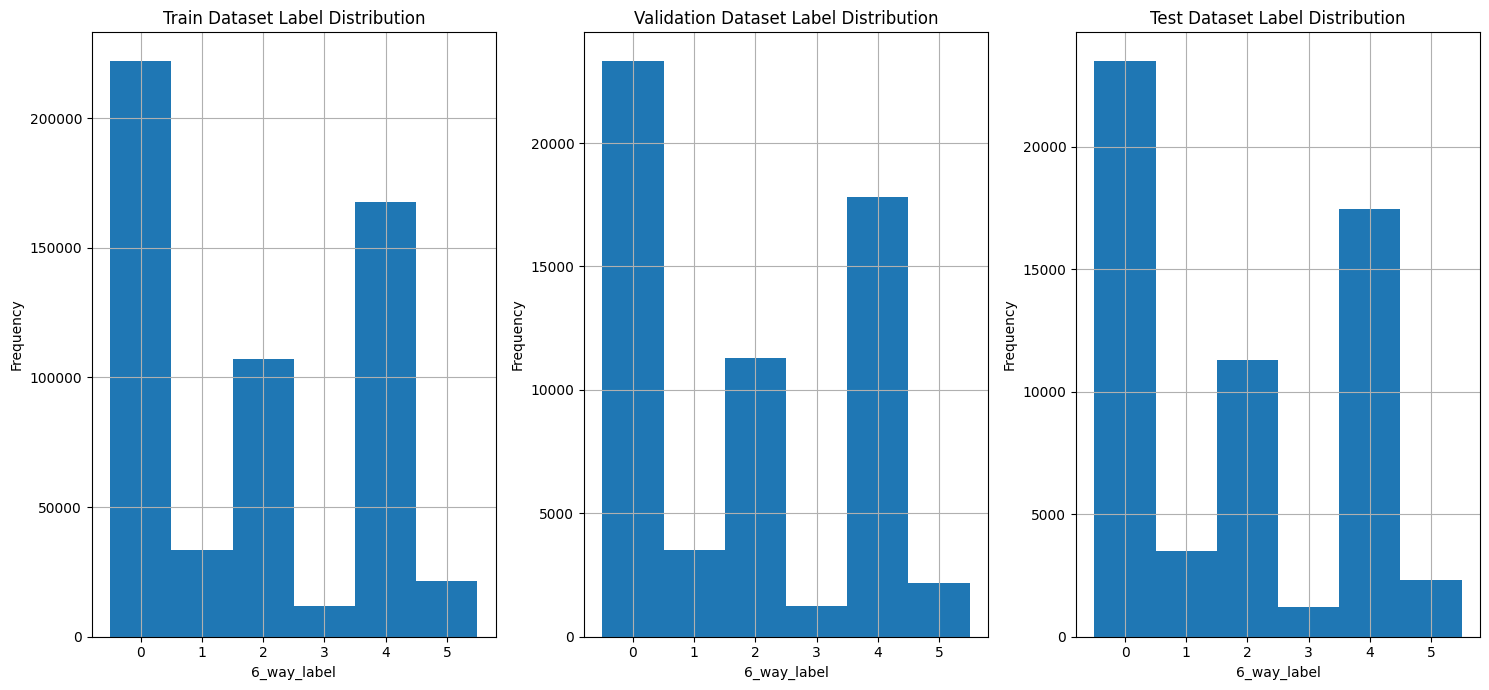

In [34]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 3, figsize=(15,7))

datasets = {'Train': df_train, 'Validation': df_validate, 'Test': df_test}

for i, (name, df) in enumerate(datasets.items()):
    df['6_way_label'].hist(ax=axes[i], bins=range(7), align='left')
    axes[i].set_title(f'{name} Dataset Label Distribution')
    axes[i].set_xlabel('6_way_label')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xticks(range(6)) # Assuming labels are 0-5

plt.tight_layout()
plt.show()

In [35]:
df_train['6_way_label'].value_counts()

,count
6_way_label,
0,222081
4,167857
2,107221
1,33481
5,21576
3,11784


In [36]:
from sklearn.model_selection import train_test_split

In [37]:
df.columns

Index(['clean_title', '6_way_label'], dtype='object')

In [38]:
df['6_way_label'].unique()

array([4, 0, 5, 2, 1, 3])

0: TRUE,
1: SATIRE,
2: FALSE CONNECTION,
3: IMPOSTER CONTENT,
4: MANIPULATED CONTENT,
5: MISLEADING CONTENT

In [39]:
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer
import torch

class Fakeddit_dataset(Dataset):
  def __init__(self,df,max_len=128):
    self.data=df
    self.tokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    self.max_len=max_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):

    text=self.data.iloc[idx]['clean_title']
    label=self.data.iloc[idx]['6_way_label']

    input=self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt',
    )

    return input['input_ids'].squeeze(0), input['attention_mask'].squeeze(0), torch.tensor(label, dtype=torch.long)




In [40]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Downsample Train DF to 10,000
train_data, _ = train_test_split(
    df_train,
    train_size=10000,
    stratify=train_df['6_way_label'],
    random_state=42
)

# Downsample Validation DF to 2,000
val_data, _ = train_test_split(
    df_validate,
    train_size=2000,
    stratify=validate_df['6_way_label'],
    random_state=42
)

# Downsample Test DF to 2,000
test_data, _ = train_test_split(
    df_test,
    train_size=2000,
    stratify=test_df['6_way_label'],
    random_state=42
)

print(f"Training Samples:   {len(train_data)}")
print(f"Validation Samples: {len(val_data)}")
print(f"Test Samples:       {len(test_data)}")

train_dataset = Fakeddit_dataset(train_data)
val_dataset   = Fakeddit_dataset(val_data)
test_dataset  = Fakeddit_dataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

Training Samples:   10000
Validation Samples: 2000
Test Samples:       2000


In [41]:
from transformers import DistilBertForSequenceClassification
import torch.nn as nn

class FakedditClassifier(nn.Module):
    def __init__(self, num_labels=6):
        super(FakedditClassifier, self).__init__()

        # Load the pre-trained model
        self.bert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

        # Freeze internal layers
        for param in self.bert.distilbert.parameters():
            param.requires_grad = False


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs[0]

In [42]:
from tqdm import tqdm

def train_epoch(model, optimizer, criterion, train_loader):
    model.train()
    train_loss = 0
    train_acc = 0

    for input_ids, attention_mask, labels in tqdm(train_loader, desc='Training'):
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == labels.to(device)).sum().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)

    return train_loss, train_acc

In [43]:
def eval_epoch(model, criterion, val_loader):
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for input_ids, attention_mask, labels in tqdm(val_loader, desc='Validation'):
            outputs = model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device))
            loss = criterion(outputs, labels.to(device))

            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == labels.to(device)).sum().item()

        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)

    return val_loss, val_acc

In [44]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FakedditClassifier().to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0

for epoch in range(15):
    train_loss, train_acc = train_epoch(model, optimizer, criterion, train_loader)
    val_loss, val_acc = eval_epoch(model, criterion, val_loader)

    print(f'Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}')

    if val_acc > best_val_acc:
        torch.save(model.state_dict(), 'best_model.pt')
        best_val_acc = val_acc

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 63/63 [00:06<00:00,  9.16it/s]


Epoch 1: Train Loss=1.4478, Train Acc=0.4462, Val Loss=1.3138, Val Acc=0.5720


Validation: 100%|██████████| 63/63 [00:07<00:00,  8.94it/s]


Epoch 2: Train Loss=1.2709, Train Acc=0.5651, Val Loss=1.2196, Val Acc=0.5860


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.27it/s]


Epoch 3: Train Loss=1.1920, Train Acc=0.5852, Val Loss=1.1584, Val Acc=0.6065


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.14it/s]


Epoch 4: Train Loss=1.1377, Train Acc=0.5997, Val Loss=1.1140, Val Acc=0.6135


Validation: 100%|██████████| 63/63 [00:07<00:00,  8.99it/s]


Epoch 5: Train Loss=1.0956, Train Acc=0.6120, Val Loss=1.0838, Val Acc=0.6195


Validation: 100%|██████████| 63/63 [00:07<00:00,  8.88it/s]


Epoch 6: Train Loss=1.0719, Train Acc=0.6161, Val Loss=1.0638, Val Acc=0.6250


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.21it/s]


Epoch 7: Train Loss=1.0520, Train Acc=0.6216, Val Loss=1.0470, Val Acc=0.6305


Validation: 100%|██████████| 63/63 [00:07<00:00,  8.42it/s]


Epoch 8: Train Loss=1.0316, Train Acc=0.6260, Val Loss=1.0332, Val Acc=0.6325


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.09it/s]


Epoch 9: Train Loss=1.0169, Train Acc=0.6327, Val Loss=1.0184, Val Acc=0.6380


Validation: 100%|██████████| 63/63 [00:07<00:00,  8.95it/s]


Epoch 10: Train Loss=1.0072, Train Acc=0.6374, Val Loss=1.0072, Val Acc=0.6375


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.52it/s]


Epoch 11: Train Loss=0.9981, Train Acc=0.6380, Val Loss=0.9981, Val Acc=0.6375


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.20it/s]


Epoch 12: Train Loss=0.9850, Train Acc=0.6429, Val Loss=0.9905, Val Acc=0.6460


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.21it/s]


Epoch 13: Train Loss=0.9797, Train Acc=0.6407, Val Loss=0.9823, Val Acc=0.6480


Validation: 100%|██████████| 63/63 [00:07<00:00,  8.92it/s]


Epoch 14: Train Loss=0.9706, Train Acc=0.6467, Val Loss=0.9747, Val Acc=0.6535


Validation: 100%|██████████| 63/63 [00:07<00:00,  8.88it/s]

Epoch 15: Train Loss=0.9632, Train Acc=0.6497, Val Loss=0.9722, Val Acc=0.6475


In [45]:
best_model = FakedditClassifier().to(device)
best_model.load_state_dict(torch.load('best_model.pt'))

# 4. Run Evaluation
test_loss, test_acc = eval_epoch(best_model, criterion, test_loader)

print("="*30)
print(f"FINAL TEST RESULTS")
print("="*30)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss:     {test_loss:.4f}")
print("="*30)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 63/63 [00:06<00:00,  9.12it/s]

FINAL TEST RESULTS
Test Accuracy: 0.6745
Test Loss:     0.9315


Generating predictions...


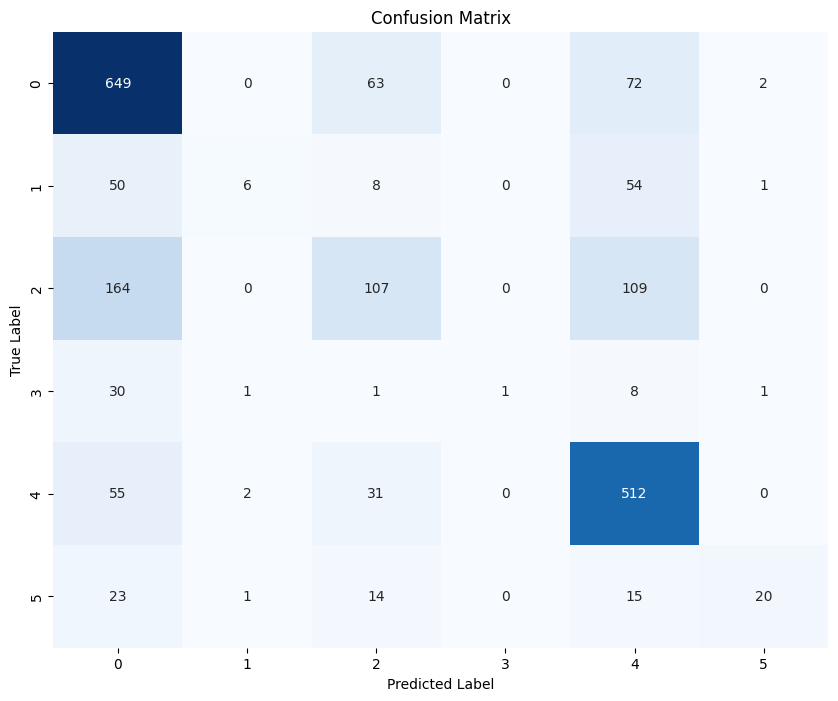

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def get_all_preds(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in loader:

            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[-1].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

print("Generating predictions...")
preds, labels = get_all_preds(model, val_loader)
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [48]:
from sklearn.metrics import classification_report

# Class: ['True', 'Satire', 'False Connection', 'Imposter', 'Manipulated', 'Misleading']
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

print("-----------------------------------------------------------")
print("                CLASSIFICATION REPORT")
print("-----------------------------------------------------------")

report = classification_report(labels, preds, target_names=class_names, digits=4)
print(report)

-----------------------------------------------------------
                CLASSIFICATION REPORT
-----------------------------------------------------------
              precision    recall  f1-score   support

     Class 0     0.6684    0.8257    0.7388       786
     Class 1     0.6000    0.0504    0.0930       119
     Class 2     0.4777    0.2816    0.3543       380
     Class 3     1.0000    0.0238    0.0465        42
     Class 4     0.6649    0.8533    0.7474       600
     Class 5     0.8333    0.2740    0.4124        73

    accuracy                         0.6475      2000
   macro avg     0.7074    0.3848    0.3987      2000
weighted avg     0.6400    0.6475    0.6034      2000

